Note:  This notebook has widgets to select the state, congressional district and facility.  Those currently work only when the cells are run one at a time sequentially, not all at once.

## Clean Air Act Inspections Evaluations by Congressional District

This notebook examines ECHO data on air inspections, the means by which EPA and state environmental agencies check facilities for their compliance with the Clean Air Act. This notebook draws mainly on the ECHO downloadable file ICIS_FEC_EPA_INSPECTIONS. 
The fields in this table are:
<ol>
    <li>REGISTRY_ID, </li>
    <li>STATUTE_CODE, </li>
    <li>ACTUAL_BEGIN_DATE</li>

The REGISTRY_ID identifier is linked to the ECHO_EXPORTER table's field of the same name.

The STATUTE_CODE of interest for this notebook is 'CAA'.
    
A state and congressional district must be chosen using the dropdown
widgets that are provided.

In [1]:
# Import libraries
import urllib.parse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import folium

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display


Run this next cell, select a state, and then run the following cell.

In [2]:
states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]
dropdown_state=widgets.Dropdown(
    options=states,
    value='NY',
    description='State:',
    disabled=False,
)
output_state = widgets.Output()
my_state = ""

def dropdown_state_eventhandler( change ):
    output_state.clear_output()
    value = change.new
    with output_state:
        display( change.new )
            
dropdown_state.observe( dropdown_state_eventhandler, names='value')
display( dropdown_state )

Dropdown(description='State:', index=32, options=('AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', …

In [3]:
my_state = dropdown_state.value

sql = "select REGISTRY_ID, FAC_NAME, FAC_STATE, FAC_LAT, FAC_LONG, FAC_DERIVED_CD113 " + \
    " from ECHO_EXPORTER where AIR_FLAG = 'Y' and FAC_STATE = '" + my_state + "'"
url='http://apps.tlt.stonybrook.edu/echoepa/?query='
data_location=url+urllib.parse.quote(sql)
print(sql)
print(data_location)


select REGISTRY_ID, FAC_NAME, FAC_STATE, FAC_LAT, FAC_LONG, FAC_DERIVED_CD113  from ECHO_EXPORTER where AIR_FLAG = 'Y' and FAC_STATE = 'NY'
http://apps.tlt.stonybrook.edu/echoepa/?query=select%20REGISTRY_ID%2C%20FAC_NAME%2C%20FAC_STATE%2C%20FAC_LAT%2C%20FAC_LONG%2C%20FAC_DERIVED_CD113%20%20from%20ECHO_EXPORTER%20where%20AIR_FLAG%20%3D%20%27Y%27%20and%20FAC_STATE%20%3D%20%27NY%27


In [4]:
try:
    echo_data = pd.read_csv(data_location,encoding='iso-8859-1',header = 0)
    echo_data.set_index( "REGISTRY_ID", inplace=True)
except:
    print( "No data for " + my_state )

Run this next cell after choosing a state from the dropdown list.

In [5]:
num_facilities = echo_data.shape[0]
print("There are %s ICIS facilities in %s tracked in the ECHO database." %(num_facilities, my_state))

There are 12464 ICIS facilities in NY tracked in the ECHO database.


Run this next cell to generate the Congressional District dropdown list for your state.  Then select a CD and run the following cell.

In [6]:
if (( my_state != 'none' ) & (my_state != 'all' )):
    cd_array = echo_data["FAC_DERIVED_CD113"].fillna(0).astype(int).unique()
    cd_array.sort()
    w2=widgets.Dropdown(
        options=cd_array,
        value=1,
        description='Congressional Districts:',
        disabled=False,
    )
    display(w2)

Dropdown(description='Congressional Districts:', index=1, options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1…

Here is a map of congressional districts: https://www.govtrack.us/congress/members/map

Run this next cell after choosing a congressional district from the dropdown list.

In [22]:
my_cd = w2.value
my_cd_facs = echo_data[echo_data["FAC_DERIVED_CD113"].fillna(0).astype(int) == my_cd]
num_facilities = my_cd_facs.shape[0]    
print("There are %s ICIS facilities in %s district %s tracked in the ECHO database." %(num_facilities, my_state, my_cd))

There are 400 ICIS facilities in NY district 1 tracked in the ECHO database.


Next look up the compliance monitoring history for the facilities in the selected
state and congressional district.  This step may take awhile.

In [23]:
# sql = "select PGM_SYS_ID, STATE_EPA_FLAG, AGENCY_TYPE_DESC, COMP_MONITOR_DESC, ACTUAL_END_DATE from `ICIS-AIR_FCES_PCES` where STATE_CODE='" + my_state + "'"
url='http://apps.tlt.stonybrook.edu/echoepa/?query='

sql = "select REGISTRY_ID, STATUTE_CODE, ACTUAL_END_DATE from `ICIS_FEC_EPA_INSPECTIONS` " + \
    "where STATUTE_CODE = 'CAA'"
# sql = "show columns from `ICIS_FEC_EPA_INSPECTIONS`"
# sql = "show tables from slim_echoepa_a"
data_location=url+urllib.parse.quote(sql)
print(sql)
print(data_location)

select REGISTRY_ID, STATUTE_CODE, ACTUAL_END_DATE from `ICIS_FEC_EPA_INSPECTIONS` where STATUTE_CODE = 'CAA'
http://apps.tlt.stonybrook.edu/echoepa/?query=select%20REGISTRY_ID%2C%20STATUTE_CODE%2C%20ACTUAL_END_DATE%20from%20%60ICIS_FEC_EPA_INSPECTIONS%60%20where%20STATUTE_CODE%20%3D%20%27CAA%27


In [24]:
icis_data = pd.read_csv(data_location,encoding='iso-8859-1',header = 0)
icis_data.set_index( "REGISTRY_ID", inplace=True)

In [37]:
icis_fac_data = pd.merge( my_cd_facs, icis_data, on='REGISTRY_ID' )
icis_facs = icis_fac_data[['FAC_NAME', 'FAC_LAT', 'FAC_LONG']].drop_duplicates()
state_icis_fac_data = pd.merge( echo_data, icis_data, on='REGISTRY_ID' )
state_icis_facs = state_icis_fac_data[['FAC_NAME', 'FAC_LAT', 'FAC_LONG']].drop_duplicates()

print( "There are %s facilities with %s inspections in the district." %(len(icis_facs), len(icis_fac_data)))
print( "There are %s facilities with %s inspections in the state." %(len(state_icis_facs), len(state_icis_fac_data)))


There are 3 facilities with 3 inspections in the district.
There are 179 facilities with 266 inspections in the state.


Map the facilities that have had these compliance evaluations, over all years contained in the ECHO data.

In [38]:
# Let's show a quick map of your area and the facilities in it

def mapper(df):
    # Initialize the map
    m = folium.Map(
        location = [df.mean()["FAC_LAT"], df.mean()["FAC_LONG"]],
        zoom_start = 9
    )

    # Add a clickable marker for each facility
    for index, row in df.iterrows():
        folium.Marker(
            location = [row["FAC_LAT"], row["FAC_LONG"]],
            popup = row["FAC_NAME"] ).add_to(m)

    # Show the map
    return m

map_of_facilities_in_my_area = mapper(icis_facs)
map_of_facilities_in_my_area

Present another dropdown with the list of names of the facilities.  Choosing a facility will display
the violations.

In [42]:
cd_array = icis_facs["FAC_NAME"].unique()
cd_array.sort()

w3=widgets.Dropdown(
    options=cd_array,
    description='Facility Name:',
    disabled=False,
)
display(w3)

Dropdown(description='Facility Name:', options=('BROOKHAVEN LANDFILL & RECYCLING AREA', 'IRS BROOKHAVEN SERVIC…

Run this next cell after choosing a facility.

In [43]:

my_inspections = icis_fac_data[icis_fac_data["FAC_NAME"] == w3.value]
my_inspections

,FAC_NAME,FAC_STATE,FAC_LAT,FAC_LONG,FAC_DERIVED_CD113,STATUTE_CODE,ACTUAL_END_DATE
REGISTRY_ID,,,,,,,
1.100008e+11,NORTHVILLE HOLTSVILLE TERMINAL,NY,40.812503,-73.065525,1.0,CAA,01/21/2003


Save the data to a CSV file in your Google Drive.
The first of the next three cells will open our Google Drive to write into.
The second cell writes the congressional district file.
The third cell writes the file for state data.
Running these cells is optional.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Write the congressional district data to CSV file.

In [ ]:
filename = '/content/drive/My Drive/cd-air-inspections-' + my_state + '-' + str( my_cd ) + '.csv'
icis_fac_data.to_csv( filename ) 
print( "Writing this data to %s" %(filename))

Write the state data to CSV file.

In [ ]:
filename = '/content/drive/My Drive/state-air-inspections-' + my_state + '.csv'
state_icis_fac_data.to_csv( filename ) 
print( "Writing this data to %s" %(filename))

## Plot the number of inspections by year for the congressional district.

                 ACTUAL_END_YEAR
ACTUAL_END_YEAR                 
2003                           1
2006                           1
2009                           1


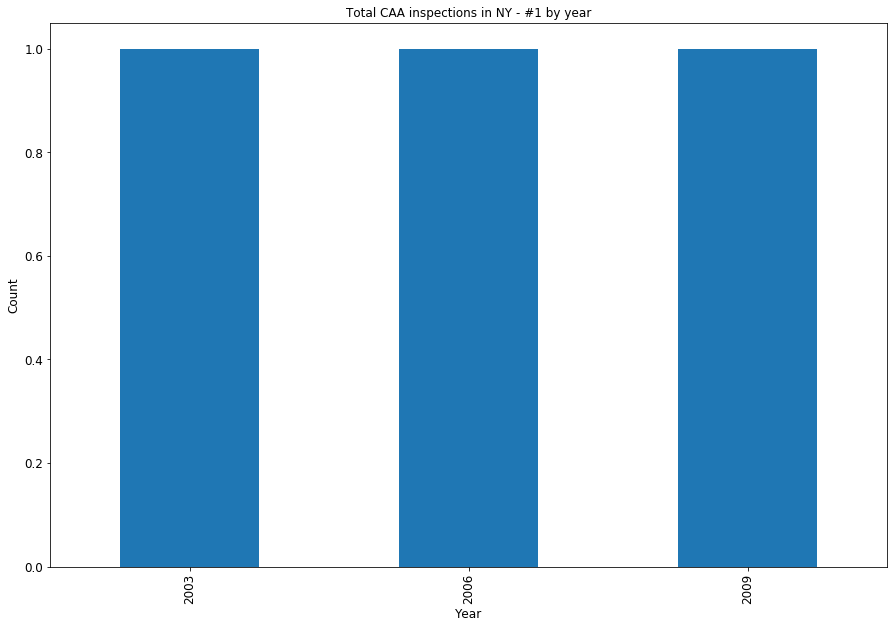

In [45]:
# This cell creates a function that will be used by both the CD and the state
# to plot the number of cases by year.
import datetime

def show_plot( df, date_field, year_field, place, date_format, chart_title ):
    format_str = date_format # The format
    nan_count = 0
    year_col = []
    for day in df[date_field]:
        try:
            viol_year = datetime.datetime.strptime(day, format_str).year
            year_col.append( viol_year )
        except:
            nan_count += 1
            year_col.append(  np.NaN )
    df[year_field] = year_col
    
    year_groups = df.groupby( year_field )[[ year_field ]]
    counted_years = year_groups.count()

    # Print how many values are present 
    print(counted_years)
    chart_title +=  " in " + place + " by year"

    ax = counted_years[[year_field]].plot(kind='bar', title = chart_title, figsize=(15, 10), legend=False, fontsize=12)
    ax.set_xlabel("Year", fontsize=12)
    ax.set_ylabel("Count", fontsize=12)
    

chart_title = "Total CAA inspections"

show_plot( icis_fac_data, 'ACTUAL_END_DATE', 'ACTUAL_END_YEAR', \
          my_state + ' - #' + str( my_cd ), '%m/%d/%Y', chart_title )

## Plot the number of inspections by year, using the entire state.
Since the number of inspections in a single CD may be small, it can be more
interesting to look at the entire state.

                 ACTUAL_END_YEAR
ACTUAL_END_YEAR                 
1999.0                         1
2002.0                         2
2003.0                         7
2004.0                        26
2005.0                        28
2006.0                        23
2007.0                         9
2008.0                        30
2009.0                        19
2010.0                        13
2011.0                        14
2012.0                        29
2013.0                        16
2014.0                        16
2015.0                         2
2016.0                        13
2017.0                        10
2018.0                         3
2019.0                         3


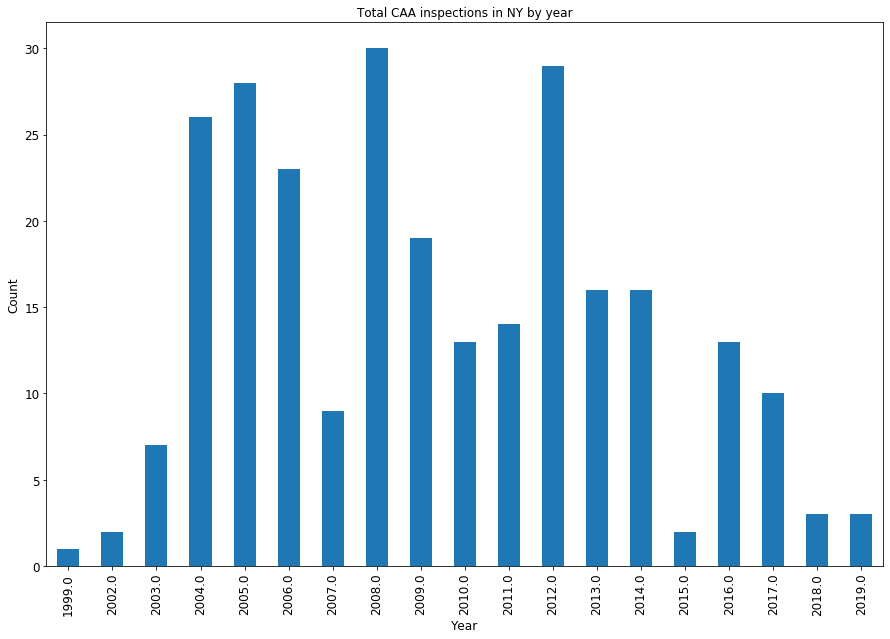

In [46]:
chart_title = "Total CAA inspections"

show_plot( state_icis_fac_data, 'ACTUAL_END_DATE', 'ACTUAL_END_YEAR', my_state, \
          '%m/%d/%Y', chart_title )